# Project - Spam Filter

Dataset: [https://www.kaggle.com/datasets/venky73/spam-mails-dataset](https://www.kaggle.com/datasets/venky73/spam-mails-dataset)

## Libraries

In [63]:
import gdown
import os
import warnings
import string
import nltk

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score

warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 1. Dataset Analysis

Downloading dataset and loading it

In [21]:
!wget "https://drive.usercontent.google.com/download?export=download&authuser=0&confirm=t&id=1Yc890ZG1O6xojyZ3zyrfRu25k48VaP12" -O dataset.csv

--2024-03-18 09:41:26--  https://drive.usercontent.google.com/download?export=download&authuser=0&confirm=t&id=1Yc890ZG1O6xojyZ3zyrfRu25k48VaP12
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.16.132, 2607:f8b0:4004:c17::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.16.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5502589 (5.2M) [application/octet-stream]
Saving to: ‘dataset.csv’

dataset.csv         100%[===================>]   5.25M  22.3MB/s    in 0.2s    

2024-03-18 09:41:26 (22.3 MB/s) - ‘dataset.csv’ saved [5502589/5502589]



In [24]:
if not os.path.exists("dataset.csv"):
    gdown.download(
        "https://drive.usercontent.google.com/download?export=download&authuser=0&confirm=t&id=1Yc890ZG1O6xojyZ3zyrfRu25k48VaP12",
        "dataset.csv"
    )

df = pd.read_csv('dataset.csv')

In [23]:
df.tail()

,Unnamed: 0,label,text,label_num
5166,1518,ham,Subject: put the 10 on the ft\r\nthe transport...,0
5167,404,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0
5168,2933,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0
5169,1409,ham,Subject: industrial worksheets for august 2000...,0
5170,4807,spam,Subject: important online banking alert\r\ndea...,1


In [25]:
df.columns

Index(['Unnamed: 0', 'label', 'text', 'label_num'], dtype='object')

In [26]:
df['label'].value_counts()

ham     3672
spam    1499
Name: label, dtype: int64

Plot for count of spam and ham in data

Text(0.5, 1.0, 'Number of Spam and Ham')

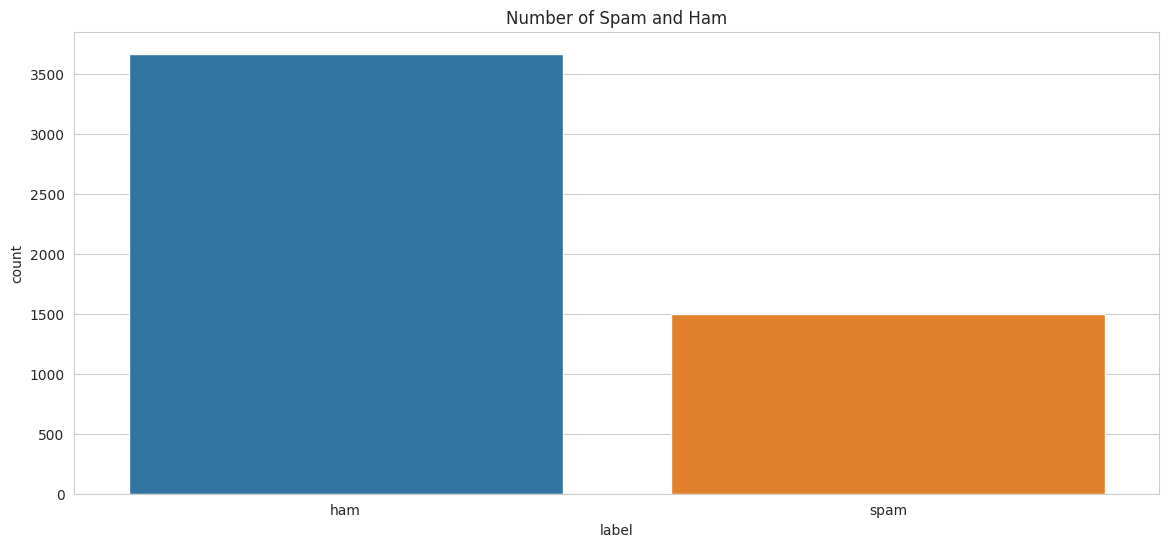

In [49]:
plt.figure(figsize=(14,6))
sns.set_style('whitegrid')
sns.countplot(
    x='label',
    data=df,
    hue='label',
)
plt.title('Number of Spam and Ham')

## 2. Data processing

Define a preprocess function to remove stopwords, digits, numbers, punctuaction, hyperlinks and apply stemming

In [28]:
import re

ps = PorterStemmer()

def preprocess_text(text):
    # Remove subject
    text = re.sub(r'Subject.*?\r\n', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Remove hyperlinks
    text = re.sub(r'http\S+', '', text)

    # Remove stopwords
    word_tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word.strip() for word in word_tokens if word.lower() not in stop_words])

    # Word stemming
    words = word_tokenize(text)
    stemmed_words = [ps.stem(word) for word in words]
    text = ' '.join(stemmed_words)

    return text

In [29]:
df['t_text'] = df['text'].apply(preprocess_text)

In [30]:
X = df['t_text']
y = df['label_num']

## 3.1 Classification with Decision Tree


Defining pipeline for Decision Tree

In [31]:
pipe_decision_tree = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', DecisionTreeClassifier(criterion='log_loss', max_depth=70))
])

Main loop with classification and plots

Misclassification rate with N = 100: 8.199574550377104
Misclassification rate with N = 500: 7.484045639141365
Misclassification rate with N = 1000: 7.097273254689615


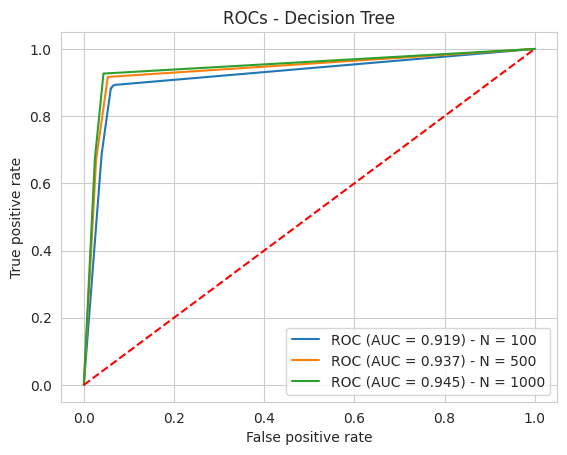

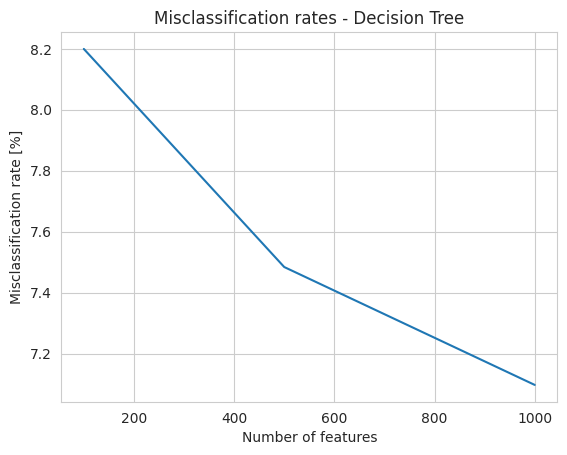

In [64]:
# k-fold Cross-Validation with 5 folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

n_features              = [100, 500, 1000]
misclassification_rate  = list()
misclassification_count = 0
total_count             = 0

for idx, n in enumerate(n_features):
    for train_idx, test_idx in skf.split(X, y):
        xtr, xts = X[train_idx], X[test_idx]
        ytr, yts = y[train_idx], y[test_idx]

        # Set number of features
        pipe_decision_tree['vectorizer'].set_params(max_features=n)

        pipe_decision_tree.fit(xtr, ytr)

        y_pred   = pipe_decision_tree.predict(xts)
        y_scores = pipe_decision_tree.predict_proba(xts)

        misclassification_count += (yts != y_pred).sum()

        total_count += len(yts)

    # Compute misclassification rate
    misclassification_rate.append(misclassification_count / total_count * 100)
    print(f"Misclassification rate with N = {n}: {misclassification_rate[idx]}")

    # Compute the ROC
    fpr, tpr, thresholds = roc_curve(yts, y_scores[:, 1])

    # Compute the AUC (area under the curve) of the ROC
    roc_auc = auc(fpr, tpr)

    # Plot ROC
    plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.3f}) - N = {n}')

# Plot ROCs
plt.title('ROCs - Decision Tree')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.savefig("rocs_decision_tree.pdf")
plt.show()

# Plot misclassication rates
plt.title('Misclassification rates - Decision Tree')
plt.xlabel('Number of features')
plt.ylabel('Misclassification rate [%]')
plt.plot(n_features, misclassification_rate)
plt.savefig("mis_rate_decision_tree.pdf")
plt.show()

# 3.2 Classification with Logistic Regression

Defining pipeline for Logistic Regression

In [52]:
pipe_logistic_regression = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LogisticRegression())
])

Main loop with classification and plots

Misclassification rate with N = 100: 7.948172500483465
Misclassification rate with N = 500: 6.285051247340939
Misclassification rate with N = 1000: 5.401920969509444


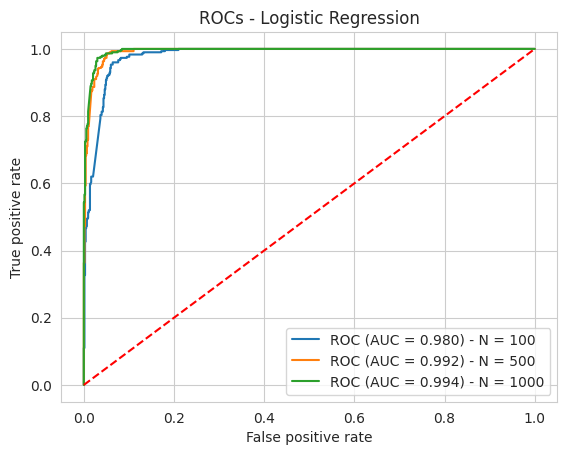

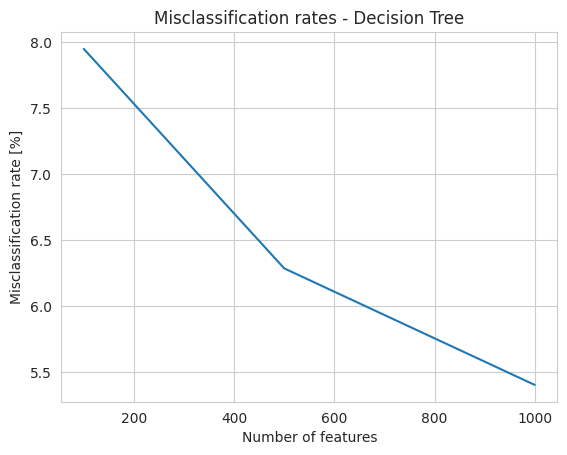

In [65]:
# k-fold Cross-Validation with 5 folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

n_features              = [100, 500, 1000]
misclassification_rate  = list()
misclassification_count = 0
total_count             = 0

for idx, n in enumerate(n_features):
    for train_idx, test_idx in skf.split(X, y):
        xtr, xts = X[train_idx], X[test_idx]
        ytr, yts = y[train_idx], y[test_idx]

        # Set number of features
        pipe_logistic_regression['vectorizer'].set_params(max_features=n)

        pipe_logistic_regression.fit(xtr, ytr)

        y_pred   = pipe_logistic_regression.predict(xts)
        y_scores = pipe_logistic_regression.decision_function(xts)

        misclassification_count += (yts != y_pred).sum()

        total_count += len(yts)

    # Compute misclassification rate
    misclassification_rate.append(misclassification_count / total_count * 100)
    print(f"Misclassification rate with N = {n}: {misclassification_rate[idx]}")

    # Compute the ROC
    fpr, tpr, thresholds = roc_curve(yts, y_scores)

    # Compute the AUC (area under the curve) of the ROC
    roc_auc = auc(fpr, tpr)

    # Plot ROC
    plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.3f}) - N = {n}')
    plt.grid()

# Plot ROCs
plt.title(f'ROCs - Logistic Regression')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.grid()
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.savefig("rocs_log_regression.pdf")
plt.show()

# Plot misclassication rates
plt.title('Misclassification rates - Decision Tree')
plt.xlabel('Number of features')
plt.ylabel('Misclassification rate [%]')
plt.plot(n_features, misclassification_rate)
plt.savefig("mis_rate_log_regressio.pdf")
plt.show()